In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def gamma_formula(n_grados_libertad: int):
    return (n_grados_libertad + 2)/n_grados_libertad

def asignar_instantes(data: pd.DataFrame) -> list[float]:
    data["Instante"] = data["t"].rank(method='dense').astype(int)
    return data

def asignar_celdas(data: pd.DataFrame) -> list[float]:
    data["Celda"] = data["x"].rank(method='dense').astype(int)
    return data

def get_data_solucion(folder_resultado: str)-> pd.DataFrame:
    
    # Obtener datos de simulación c++
    # Obtener nombre de carpeta donde se encuentran los resultados
    path_folder = f"..\\data\\{folder_resultado}\\"
    directorios = {var: path_folder + var + ".dat" for var in ["densidad", "velocidad", "presion"]}
    # Elaboración dataframe con datos de simulación c++
    data_variable = {}
    data_variable["densidad"] = pd.read_csv(directorios.get("densidad"), delimiter="\t", names=["t", "x", "rho"])
    data_variable["velocidad"] = pd.read_csv(directorios.get("velocidad"), delimiter="\t", names=["t", "x", "u"])
    data_variable["presion"] = pd.read_csv(directorios.get("presion"), delimiter="\t", names=["t", "x", "p"])
    # Asignar CORRELATIVO de instantes
    data_variable = {x: asignar_instantes(data_variable[x]) for x in data_variable.keys()}
    datos = data_variable["densidad"].join(data_variable["velocidad"]["u"]).join(data_variable["presion"]["p"])
    # Asignar CORRELATIVO de celdas
    datos = asignar_celdas(datos)
    return datos

def calcular_energia(gamma, rho, u, p):
    e_interna = p/(gamma-1)
    e_cinetica = 0.5*rho*u**2
    return e_interna + e_cinetica

def calcular_entropia(gamma, rho, p):
    return np.log(p/rho**(gamma))



In [18]:
ndegrees = [5,16,32]
gammas_a_utilizar = [gamma_formula(x) for x in ndegrees]
ndegrees_gammas = tuple((x, gamma_formula(x)) for x in ndegrees)

folder_names = ["gamma" + str(x) for x in gammas_a_utilizar]


for nombre in folder_names:
    data_to_join = get_data_solucion(nombre)
    if folder_names.index(nombre) == 0:
        data_to_join = data_to_join[["Instante", "Celda", "t", "x", "rho", "u", "p"]]
        data_to_join = data_to_join.rename(columns={"rho": "rho_"+nombre, "u": "u_"+nombre, "p": "p_"+nombre})
        data = data_to_join
    else:
        data_to_join = data_to_join[["Instante", "Celda", "rho", "u", "p"]]
        data_to_join = data_to_join.rename(columns={"rho": "rho_"+nombre, "u": "u_"+nombre, "p": "p_"+nombre})
        data = pd.merge(data, data_to_join, on=["Instante", "Celda"])

data
# Asignar energía y entropía
for gamma in gammas_a_utilizar:
    nombre_solucion = "gamma"+str(gamma)
    col_energia = "energia_" + nombre_solucion
    col_entropia = "entropia_" + nombre_solucion
    data[col_energia] = calcular_energia(gamma, data["rho_"+nombre_solucion], data["u_"+nombre_solucion], data["p_"+nombre_solucion])
    data[col_entropia] = calcular_entropia(gamma, data["rho_"+nombre_solucion], data["p_"+nombre_solucion])

data

,Instante,Celda,t,x,rho_gamma1.4,u_gamma1.4,p_gamma1.4,rho_gamma1.125,u_gamma1.125,p_gamma1.125,rho_gamma1.0625,u_gamma1.0625,p_gamma1.0625,energia_gamma1.4,entropia_gamma1.4,energia_gamma1.125,entropia_gamma1.125,energia_gamma1.0625,entropia_gamma1.0625
0,1,1,0.0,0.00,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,7.500000,-0.439445,24.000000,-0.137327,48.000000,-0.068663
1,1,2,0.0,0.02,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,7.500000,-0.439445,24.000000,-0.137327,48.000000,-0.068663
2,1,3,0.0,0.04,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,7.500000,-0.439445,24.000000,-0.137327,48.000000,-0.068663
3,1,4,0.0,0.06,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,7.500000,-0.439445,24.000000,-0.137327,48.000000,-0.068663
4,1,5,0.0,0.08,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,3.00000,0.000000,3.00000,7.500000,-0.439445,24.000000,-0.137327,48.000000,-0.068663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,6,496,4.0,9.90,1.44997,0.464329,1.69228,1.60693,0.520214,1.70973,1.65895,0.535855,1.71487,4.387008,0.005917,13.895276,0.002719,27.676096,0.001516
2996,6,497,4.0,9.92,1.44997,0.464328,1.69228,1.60691,0.520210,1.70971,1.65889,0.535862,1.71481,4.387007,0.005917,13.895110,0.002722,27.675134,0.001519
2997,6,498,4.0,9.94,1.44997,0.464326,1.69227,1.60689,0.520202,1.70969,1.65886,0.535857,1.71477,4.386981,0.005911,13.894940,0.002724,27.674485,0.001515
2998,6,499,4.0,9.96,1.44997,0.464325,1.69227,1.60687,0.520193,1.70967,1.65883,0.535845,1.71473,4.386980,0.005911,13.894770,0.002726,27.673830,0.001511


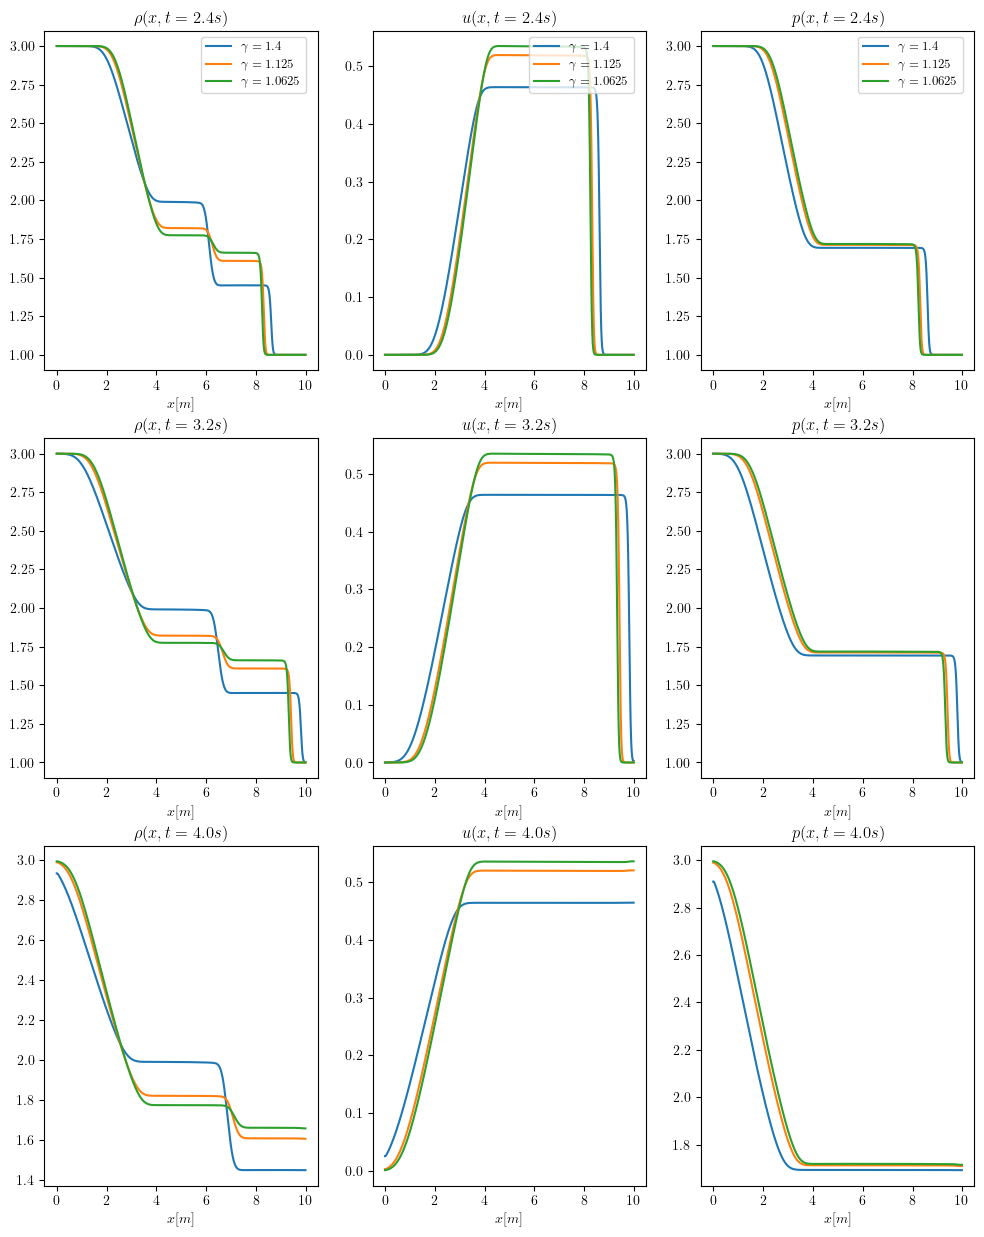

In [105]:
# prueba multiplots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

fig, lista_plots = plt.subplots(3, 3, figsize=(12, 15))
instantes = [4,5,6]
variables_datos = {"rho": {"nombre": r"$\rho$"},
                   "u": {"nombre": r"$u$"},
                   "p": {"nombre": r"$p$"}}

# print(variables_datos["rho"]["nombre"])
for i in range(len(instantes)):
    instant = instantes[i]
    data_instant = data.query("Instante == @instant")
    tiempo = data_instant["t"].values[0]
    for j in range(3):
        variable = list(variables_datos.keys())[j]
        lista_plots[i][j]: plt.Axes
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.4"], label=r"$\gamma = 1.4$")
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.125"], label=r"$\gamma = 1.125$")
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.0625"], label=r"$\gamma = 1.0625$")
        titulo = variables_datos[variable]["nombre"].replace(r"$", "")
        titulo += f"(x,t = {tiempo}s)"
        titulo = r"$" + titulo + r"$"
        lista_plots[i][j].set_title(titulo)
        lista_plots[i][j].set_xlabel(r"$x[m]$")
        if i == 0:
            lista_plots[i][j].legend(fontsize = 9, loc='upper right', bbox_to_anchor=(0.98, 1.0))
plt.savefig(f'graficas_sod/2.pdf', bbox_inches='tight', pad_inches=0.05, format='pdf')


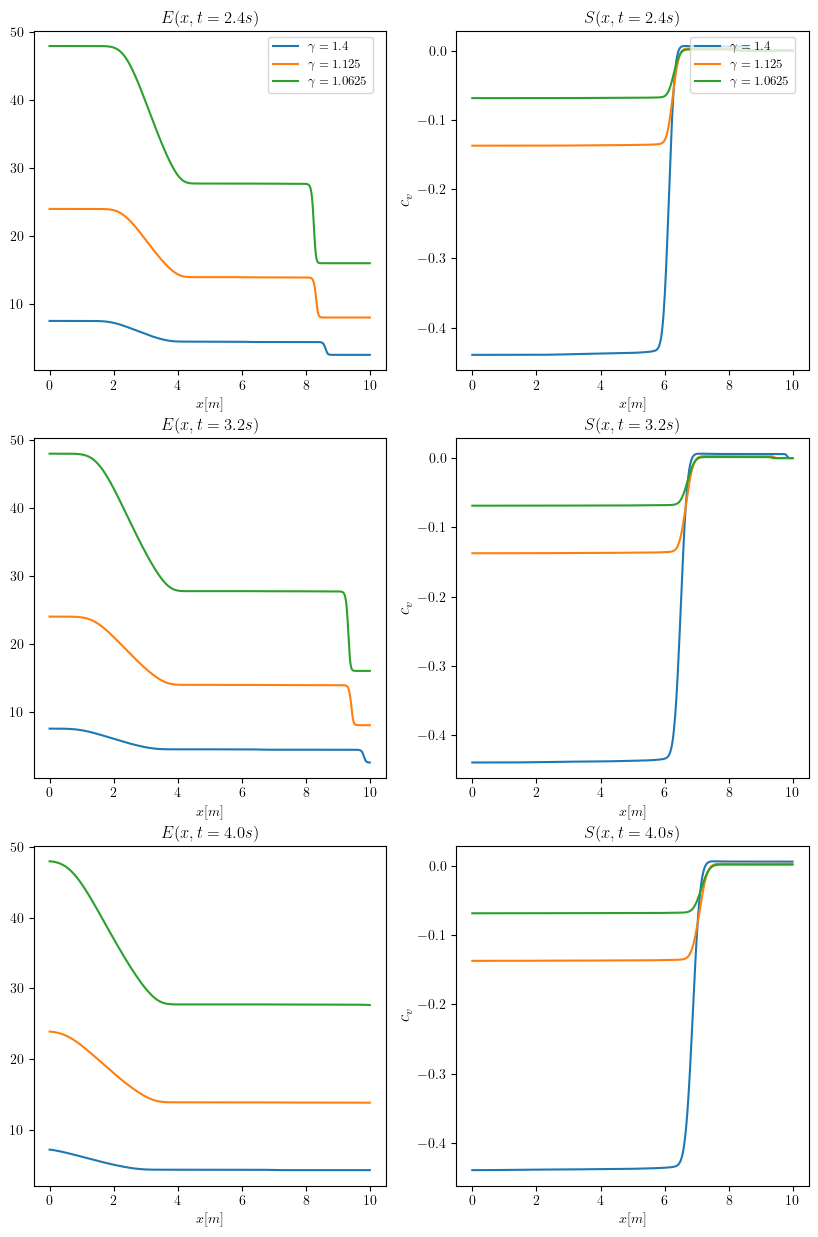

In [28]:
# Gráfica energía
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

fig, lista_plots = plt.subplots(3, 2, figsize=(10, 15))
instantes = [4,5,6]
variables_datos = {"energia": {"nombre": r"$E$"},
                   "entropia": {"nombre": r"$S$"}}

# print(variables_datos["rho"]["nombre"])
for i in range(len(instantes)):
    instant = instantes[i]
    data_instant = data.query("Instante == @instant")
    tiempo = data_instant["t"].values[0]
    for j in range(2):
        variable = list(variables_datos.keys())[j]
        lista_plots[i][j]: plt.Axes
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.4"], label=r"$\gamma = 1.4$")
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.125"], label=r"$\gamma = 1.125$")
        lista_plots[i][j].plot(data_instant["x"], data_instant[variable+"_gamma1.0625"], label=r"$\gamma = 1.0625$")
        titulo = variables_datos[variable]["nombre"].replace(r"$", "")
        titulo += f"(x,t = {tiempo}s)"
        titulo = r"$" + titulo + r"$"
        lista_plots[i][j].set_title(titulo)
        lista_plots[i][j].set_xlabel(r"$x[m]$")
        if j == 1:
            lista_plots[i][j].set_ylabel(r"$c_{v}$", fontsize=12)
        if i == 0:
            lista_plots[i][j].legend(fontsize = 9, loc='upper right', bbox_to_anchor=(0.98, 1.0))
plt.savefig(f'energia/2.pdf', bbox_inches='tight', pad_inches=0.05, format='pdf')
